# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등
 
## 접근법
- (1) 자신의 과거 값만 사용하여 미래 값을 예측하는 (y-y 모델)
 - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델이 널리 사용되었다
 - 랜덤 포레스트 등 머신러닝 모델을 사용할 수 있다
 - 신호의 패턴에 따라 성능에 한계가 있다
 - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- (2) 다양한 관련 외부 특성들을 보고 예측하는 (X-y 모델)
 - y에 영향을 주는 다양한 환경 변수들을 입력 특성 X에 포함한다
 - X에 y의 과거 값들도 포함시킬 수 있다 (위의 1을 포함하는 셈!)
 - 입력 X에 변형된 특성을 추가할 수 있다 (이동 평균, 이동 분산 등)
 - 카테고리 변수들이 많으면 X-y 모델이 편리하다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
 - 랜덤 포레스트를 주로 사용한다
- (3) 샘플(행) 단위의 예측이 아니라 입력신호의 누적 효과를 반영하는 (신경망 모델)
 - LSTM을 주로 사용한다
 - 좋은 성능을 얻으려면 학습 데이터가 충분히 많아야 한다

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 13})

## 데이터 
- 서울 자전거 대여수 예측

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               


## 데이터 다운로드

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/SeoulBikeData.csv",
                header=None)
print(df.shape)
df[:3]

(8760, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


# X-y 모델


In [23]:
df.columns = ['date', 'count', 'hour', 'temp', 'humidity',
       'wind', 'visibility', 'dew',
       'solar', 'rainfall', 'snowfall', 'seasons',
       'holiday', 'functioning']

In [24]:
df[:3]

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [25]:
df.isnull().sum().sum()

0

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8760 non-null   object 
 1   count        8760 non-null   int64  
 2   hour         8760 non-null   int64  
 3   temp         8760 non-null   float64
 4   humidity     8760 non-null   int64  
 5   wind         8760 non-null   float64
 6   visibility   8760 non-null   int64  
 7   dew          8760 non-null   float64
 8   solar        8760 non-null   float64
 9   rainfall     8760 non-null   float64
 10  snowfall     8760 non-null   float64
 11  seasons      8760 non-null   object 
 12  holiday      8760 non-null   object 
 13  functioning  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [27]:
df.loc[:,"date"] = pd.to_datetime(df.date, dayfirst=True)
df[:3]

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         8760 non-null   datetime64[ns]
 1   count        8760 non-null   int64         
 2   hour         8760 non-null   int64         
 3   temp         8760 non-null   float64       
 4   humidity     8760 non-null   int64         
 5   wind         8760 non-null   float64       
 6   visibility   8760 non-null   int64         
 7   dew          8760 non-null   float64       
 8   solar        8760 non-null   float64       
 9   rainfall     8760 non-null   float64       
 10  snowfall     8760 non-null   float64       
 11  seasons      8760 non-null   object        
 12  holiday      8760 non-null   object        
 13  functioning  8760 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(4), object(3)
memory usage: 958.2+ KB


In [29]:
df.date.min(), df.date.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 00:00:00'))

In [30]:
# 빠진 날자가 있는지 확인
pd.date_range(start = '2017-12-01', end = '2018-12-2' ).difference(df.date)

DatetimeIndex(['2018-12-01', '2018-12-02'], dtype='datetime64[ns]', freq=None)

## datetime 날짜 데이터 분해

In [31]:
df["d-year"] = df["date"].dt.year
df["d-month"] = df["date"].dt.month
df["d-day"] = df["date"].dt.day
df["d-dayofweek"] = df["date"].dt.dayofweek

df[:3].T

,0,1,2
date,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00
count,254,204,173
hour,0,1,2
temp,-5.2,-5.5,-6.0
humidity,37,38,39
wind,2.2,0.8,1.0
visibility,2000,2000,2000
dew,-17.6,-17.6,-17.7
solar,0.0,0.0,0.0
rainfall,0.0,0.0,0.0


In [32]:
df = pd.get_dummies(df, ['seasons','holiday', 'functioning'])

<AxesSubplot:xlabel='hour', ylabel='count'>

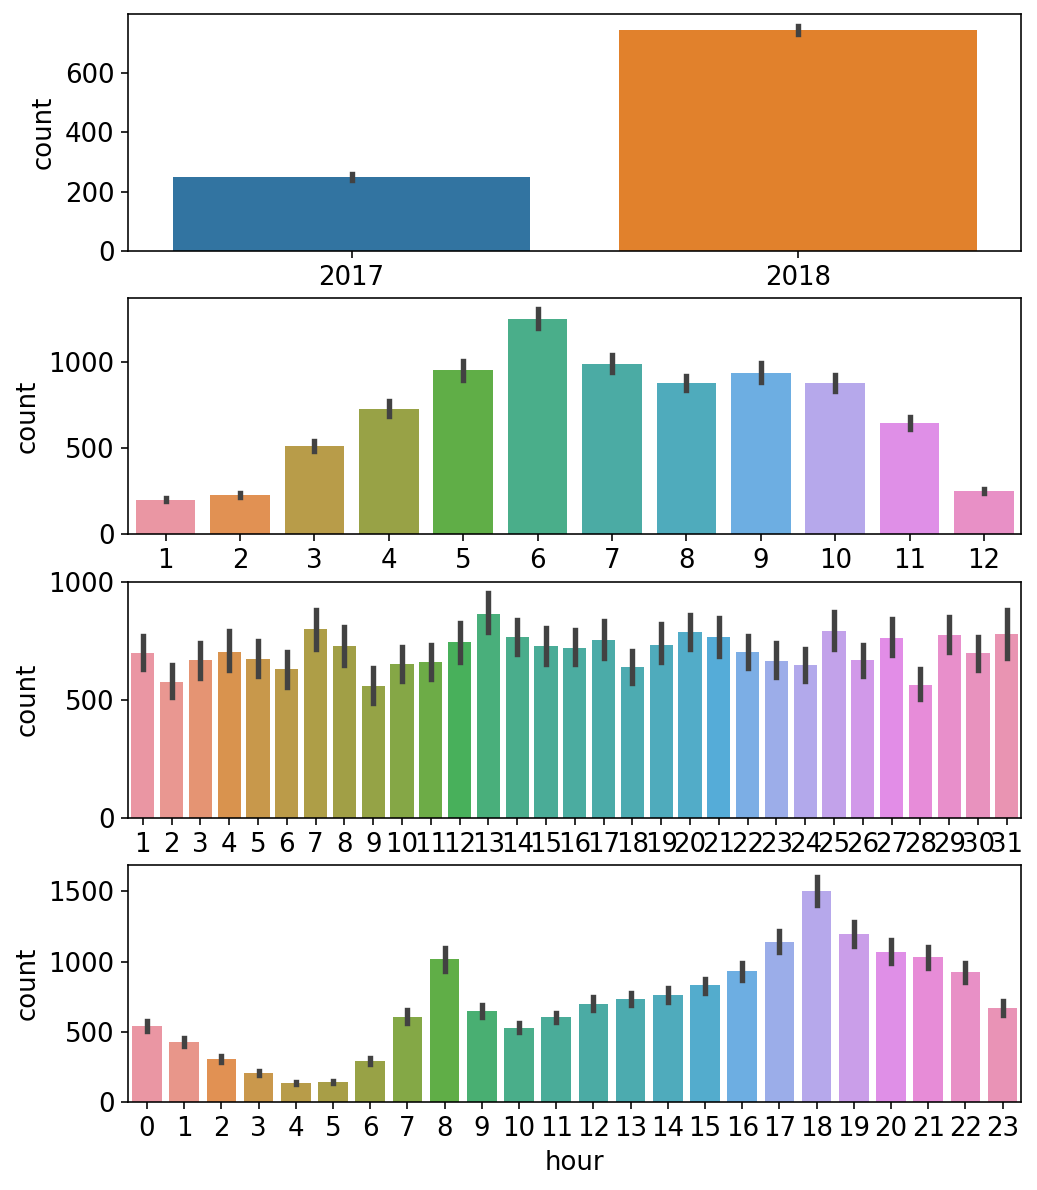

In [19]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1,
              figsize=(8,16))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.pointplot(data=df, x="hour", y="count", hue="d-dayofweek", ax=ax4)

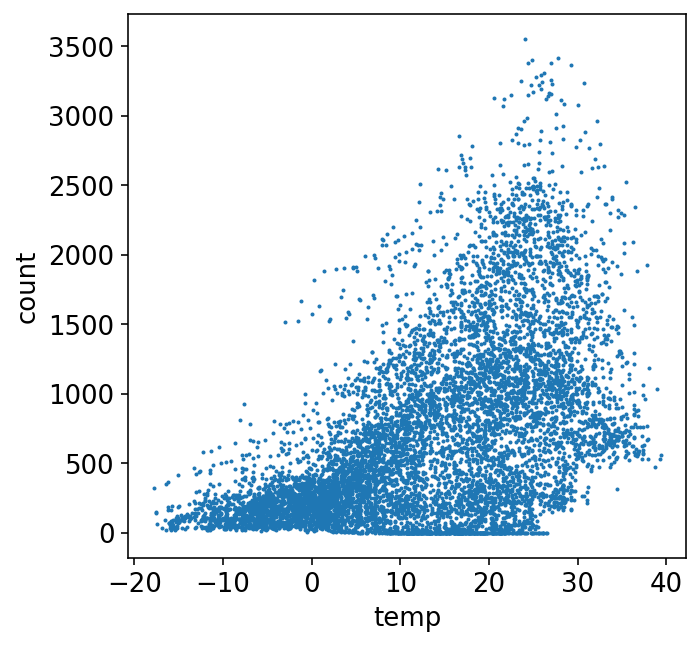

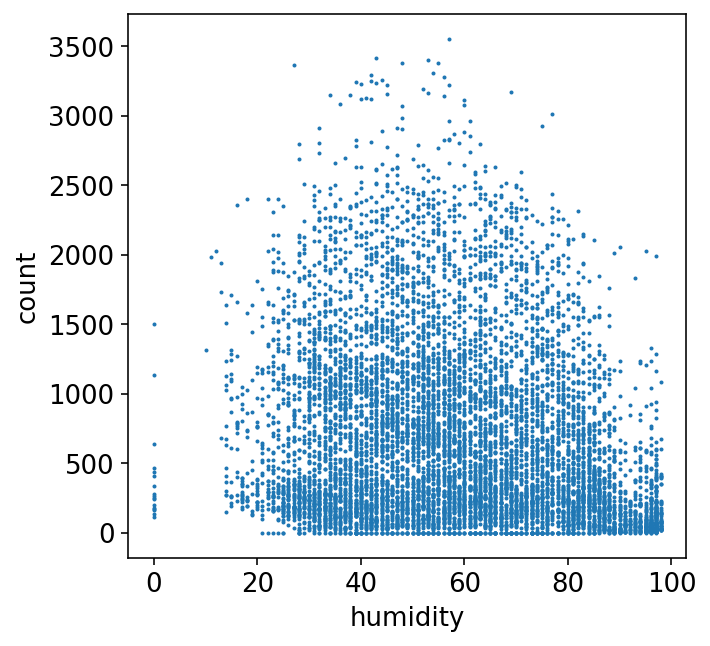

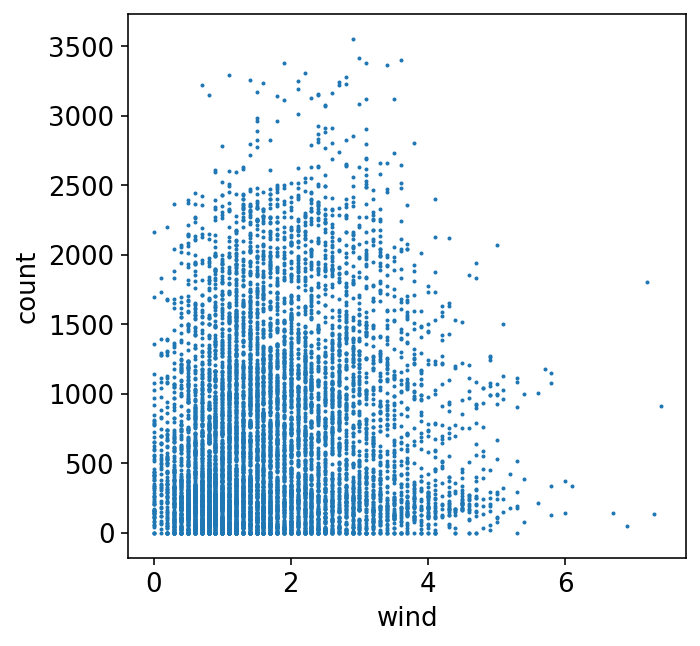

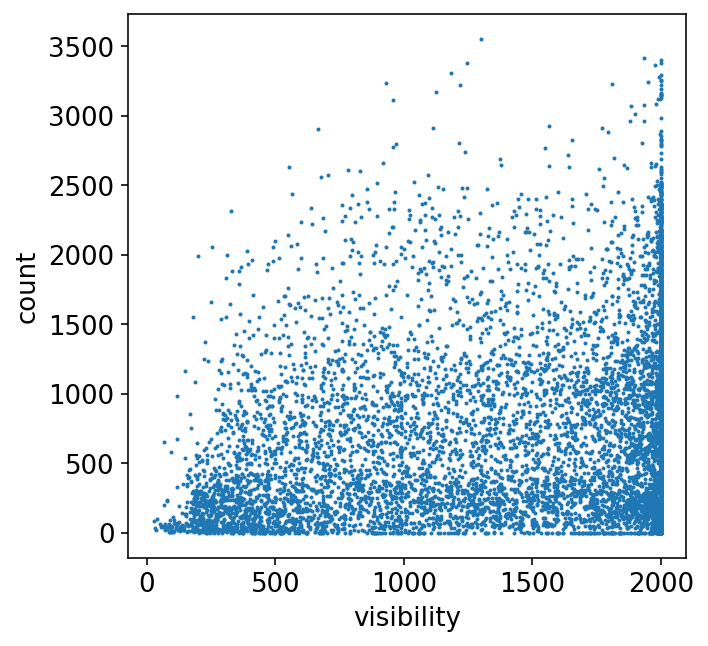

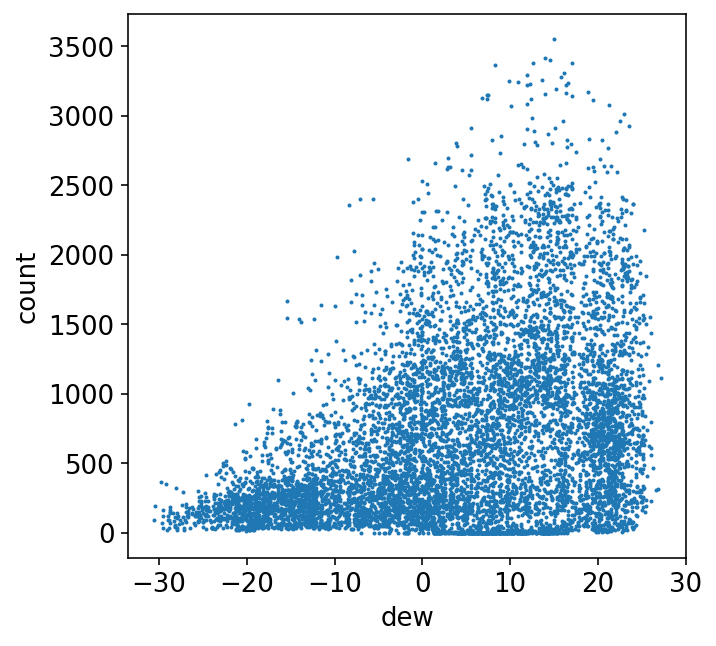

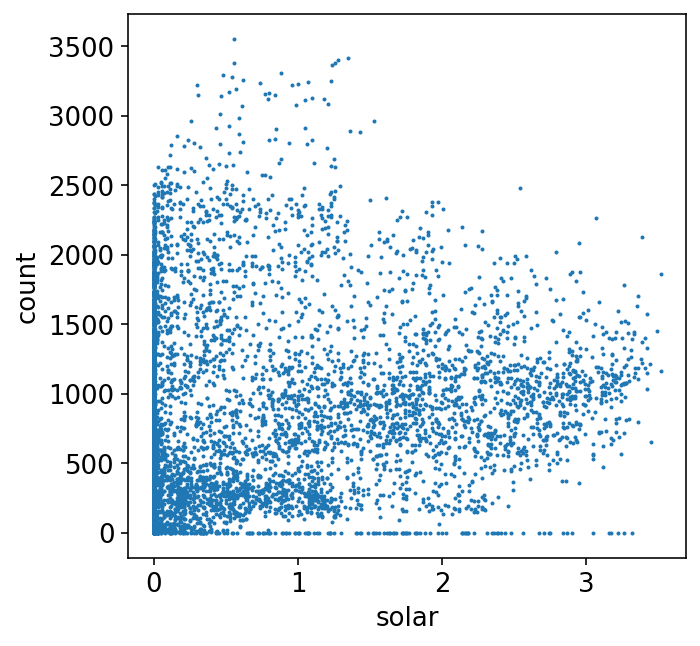

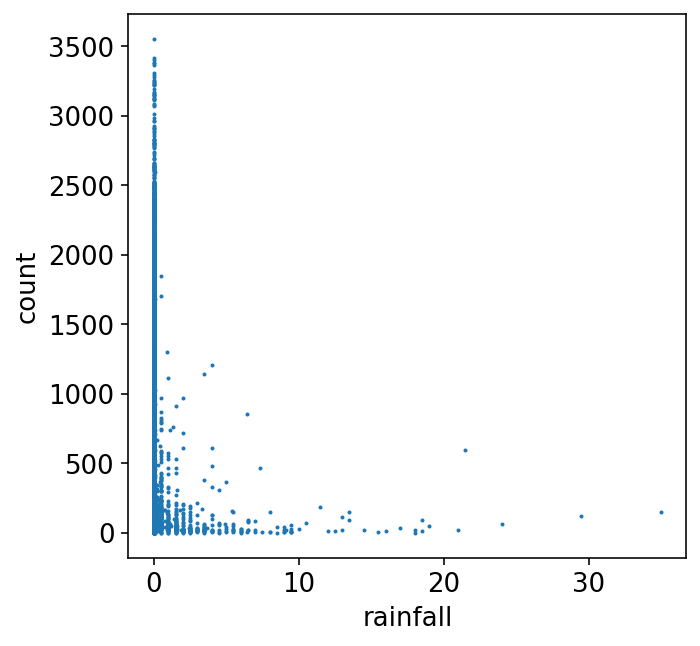

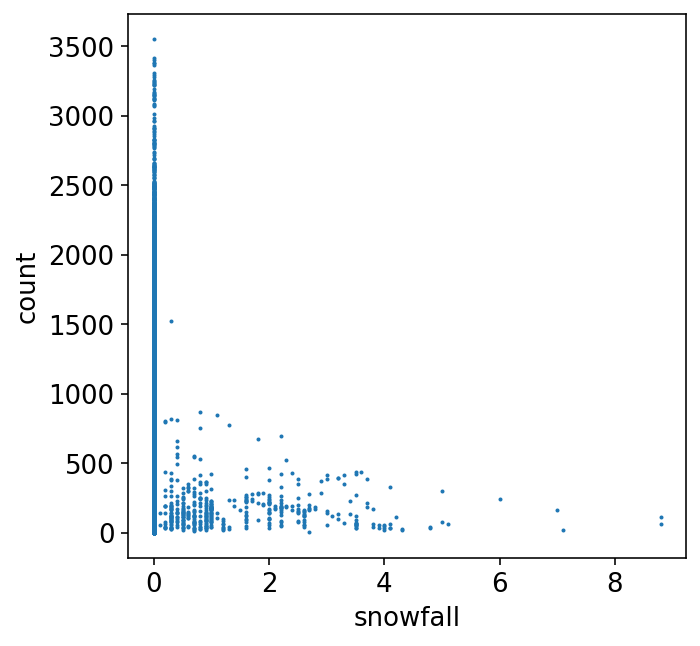

In [300]:
for col in ['temp', 'humidity',
       'wind', 'visibility', 'dew',
       'solar', 'rainfall', 'snowfall']:
    plt.figure(figsize=(5,5))
    plt.scatter(df[col] , df["count"], s=1)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.show()

## 훈련에 사용할 특성 선택

In [33]:
df.columns

Index(['date', 'count', 'hour', 'temp', 'humidity', 'wind', 'visibility',
       'dew', 'solar', 'rainfall', 'snowfall', 'd-year', 'd-month', 'd-day',
       'd-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes'],
      dtype='object')

In [37]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [38]:
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

## 랜덤 포레스트
- 지금은 시계열 데이터 예측이 아니므로 데이터를 셔플링하여 훈련/검증하겠다 (train_test_split)
- 시각 정보(hour)가 유용했다

In [39]:
features = ['hour', 'temp', 'humidity','solar', 'rainfall', 'snowfall', 'd-month',
       'd-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes']

In [40]:
X = df[features]
X[:3]

,hour,temp,humidity,solar,rainfall,snowfall,d-month,d-dayofweek,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_No,functioning_Yes
0,0,-5.2,37,0.0,0.0,0.0,12,4,0,0,0,1,0,1,0,1
1,1,-5.5,38,0.0,0.0,0.0,12,4,0,0,0,1,0,1,0,1
2,2,-6.0,39,0.0,0.0,0.0,12,4,0,0,0,1,0,1,0,1


In [41]:
y = df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  2340.94
Mean Absolute Error:  98.473
Root Mean Squared Error:  180.359
R-Squared:  0.924


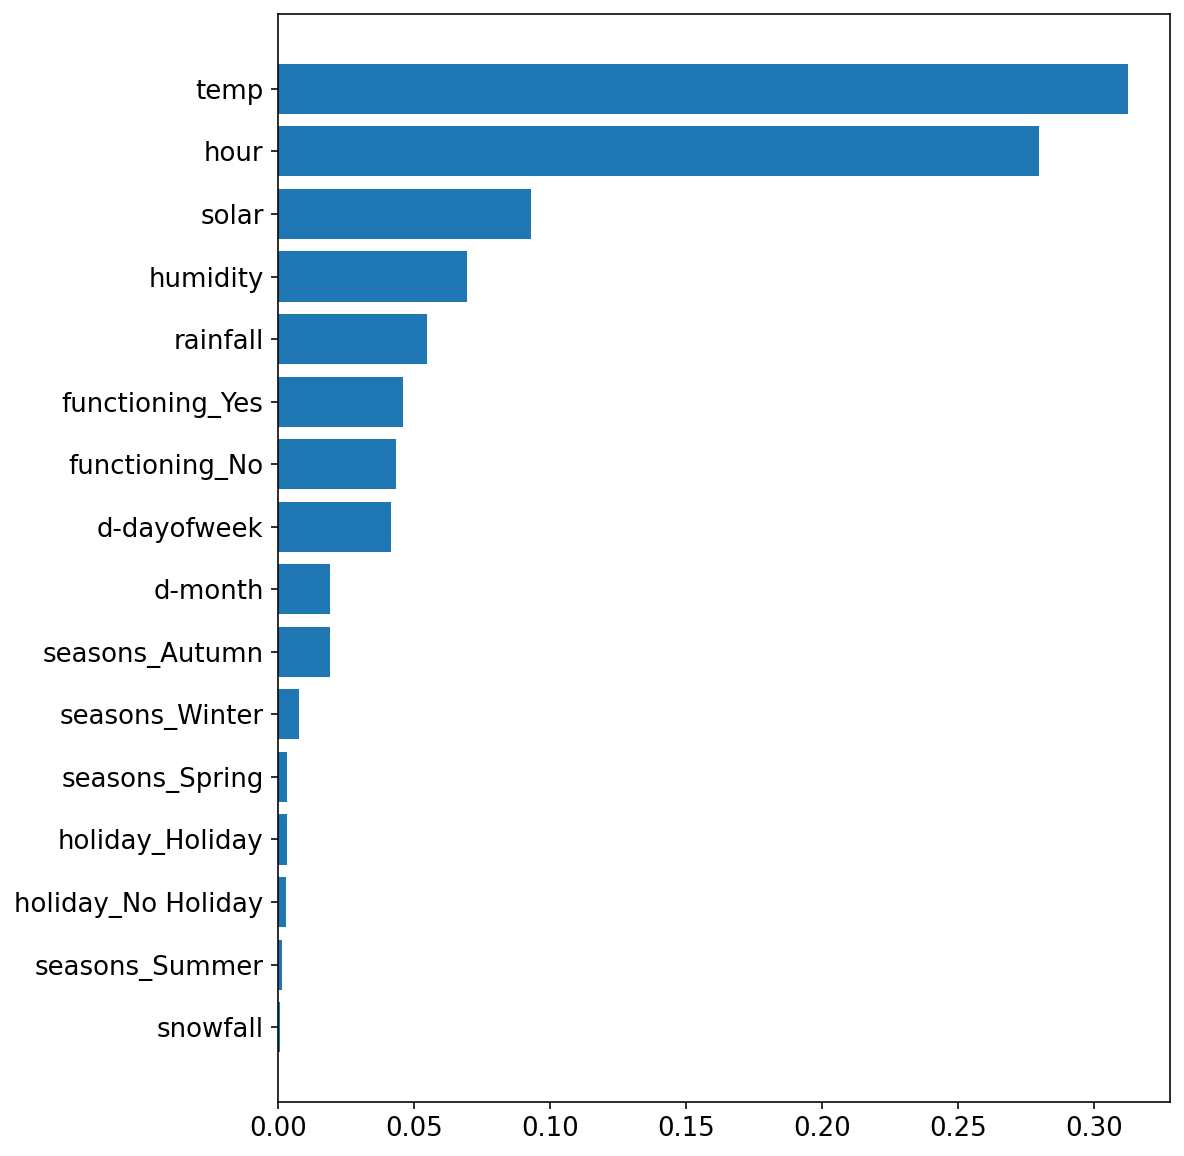

In [309]:
plot_feature_weight(X.columns, model.feature_importances_, N=20)

### 주요 특성 변수

In [310]:
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)

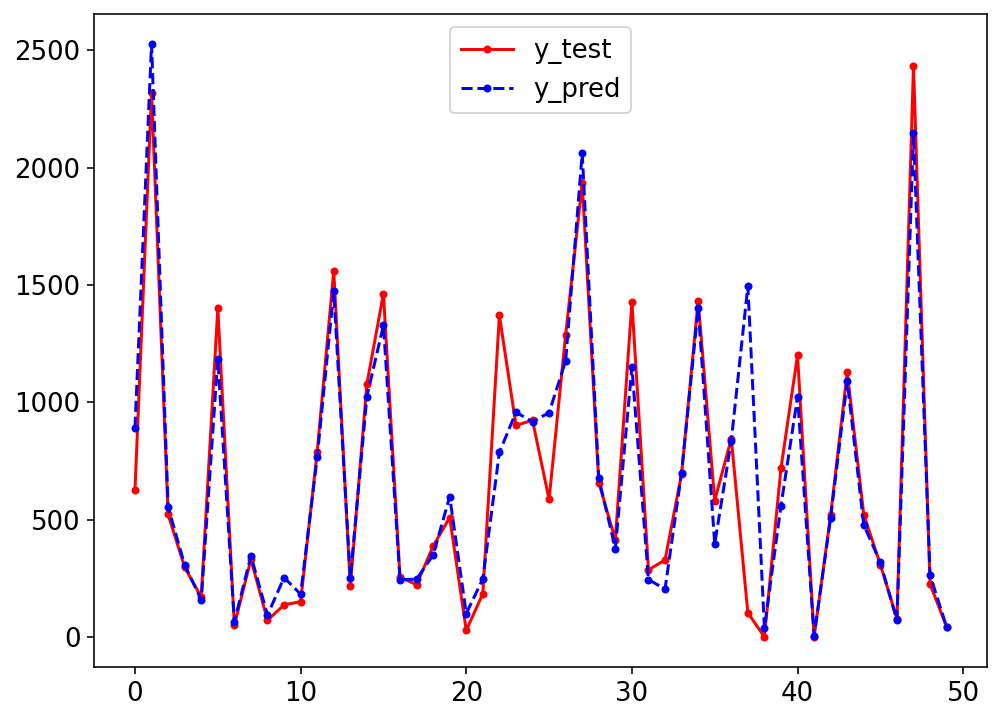

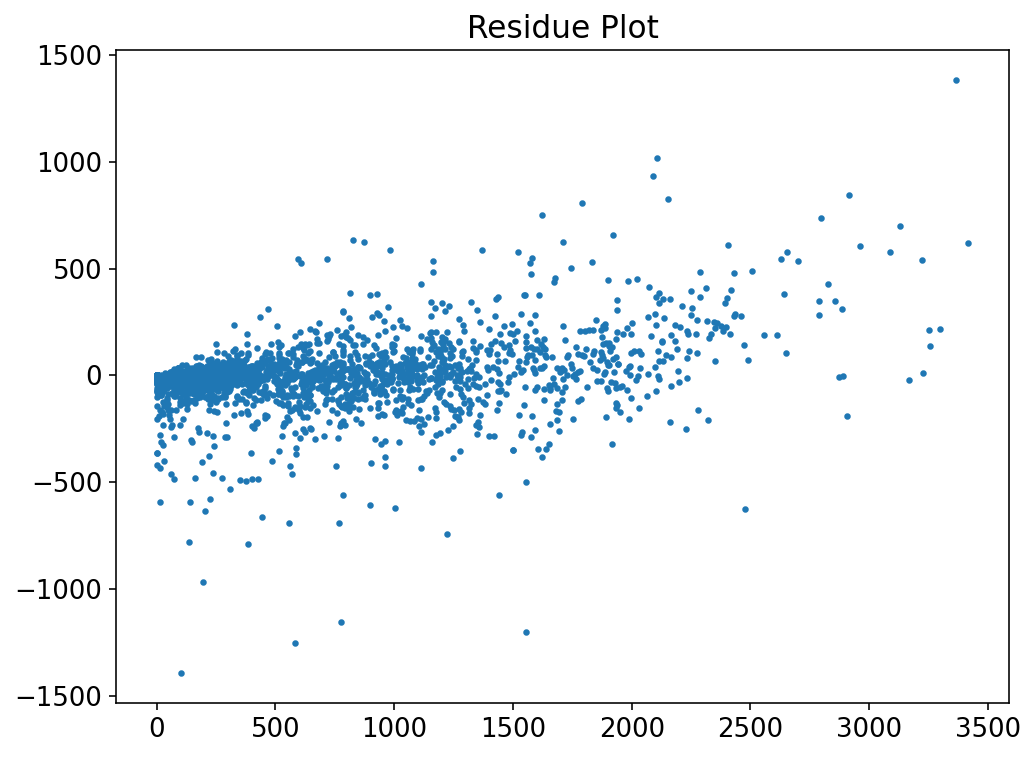

In [311]:
plot_reg_result(y_test, y_pred, N=50)

In [312]:
np.vstack((y_test[:10], y_pred[:10].round(1))).T

array([[ 626. ,  891.4],
       [2320. , 2527.1],
       [ 522. ,  553. ],
       [ 297. ,  307.3],
       [ 170. ,  158.2],
       [1401. , 1185.5],
       [  50. ,   64.4],
       [ 331. ,  346. ],
       [  71. ,   92.9],
       [ 137. ,  253.1]])

## LGBMRegressor

In [315]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
lgbm_r.score(X_test, y_test)

0.94337574374997

# 특성 선택
- 미래 예측할 날짜의 요일, 공휴일, 시간 등을 알 수 있으나
- 미래의 습도, 풍향 등은 미리 알 수가 없다
- 현실적으로 알 수 있는 특성 값만 사용하는 모데을 만들어 본다

# y-y 모델

- 단변수 시계열 예측

In [45]:
y = df["count"].values
len(y)

8760

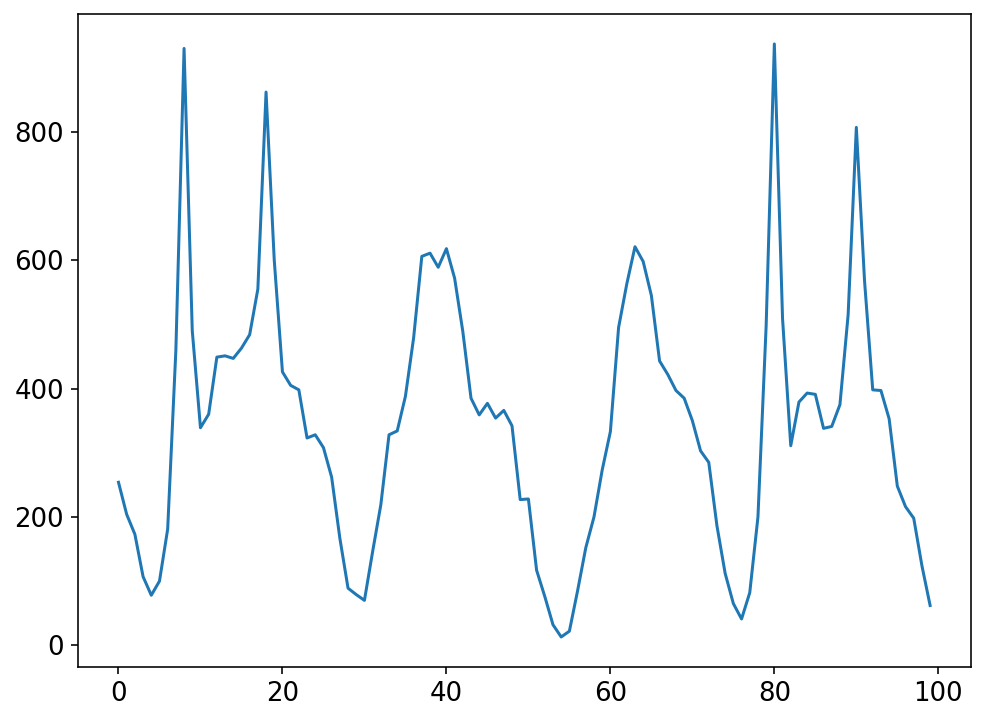

In [48]:
# 시간 단위로 보기
plt.plot(y[:100])

In [49]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누며 순서를 유지한다
train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(8760, 6570, 2190)

In [50]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

In [60]:
# 과거 몇개의 샘플을 예측에 사용할 것인지 지정 (윈도우 크기)
model = LinearRegression()
res = []
for n_steps in range(1,300, 3):

    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    res.append((n_steps, model.score(x_test, y_test).round(4))) # R2 값

<AxesSubplot:xlabel='time'>

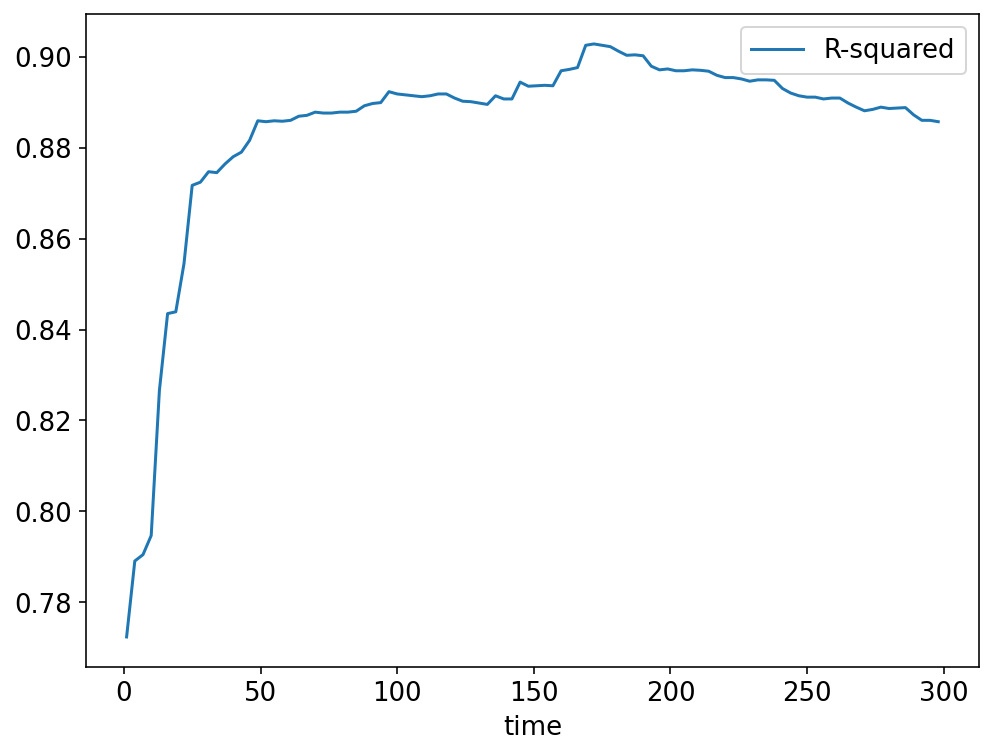

In [62]:
df_r = pd.DataFrame(res, columns=['time','R-squared']).set_index('time')
df_r.plot()

In [64]:
df_r.idxmax(), df_r.max()

(R-squared    172
 dtype: int64,
 R-squared    0.9028
 dtype: float64)

## 먼 미래 예측

In [66]:
# 입력 윈도우 n_steps_in, 멀티스텝 출력 n_steps_out
def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

In [67]:
z = np.arange(15)
split_seq_2(z, 6 ,2)

(array([[ 0,  1,  2,  3,  4,  5],
        [ 1,  2,  3,  4,  5,  6],
        [ 2,  3,  4,  5,  6,  7],
        [ 3,  4,  5,  6,  7,  8],
        [ 4,  5,  6,  7,  8,  9],
        [ 5,  6,  7,  8,  9, 10],
        [ 6,  7,  8,  9, 10, 11],
        [ 7,  8,  9, 10, 11, 12]]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14]))

In [75]:
# 먼 미래 예측
n_steps = 172

res = []
for n_future in range(1,73, 3):

    x_train, y_train = split_seq_2(train_data, n_steps, n_future)
    x_test, y_test = split_seq_2(test_data, n_steps, n_future)
    model.fit(x_train, y_train) 
    res.append((n_future, model.score(x_test, y_test).round(4))) # R2 값

<AxesSubplot:xlabel='time'>

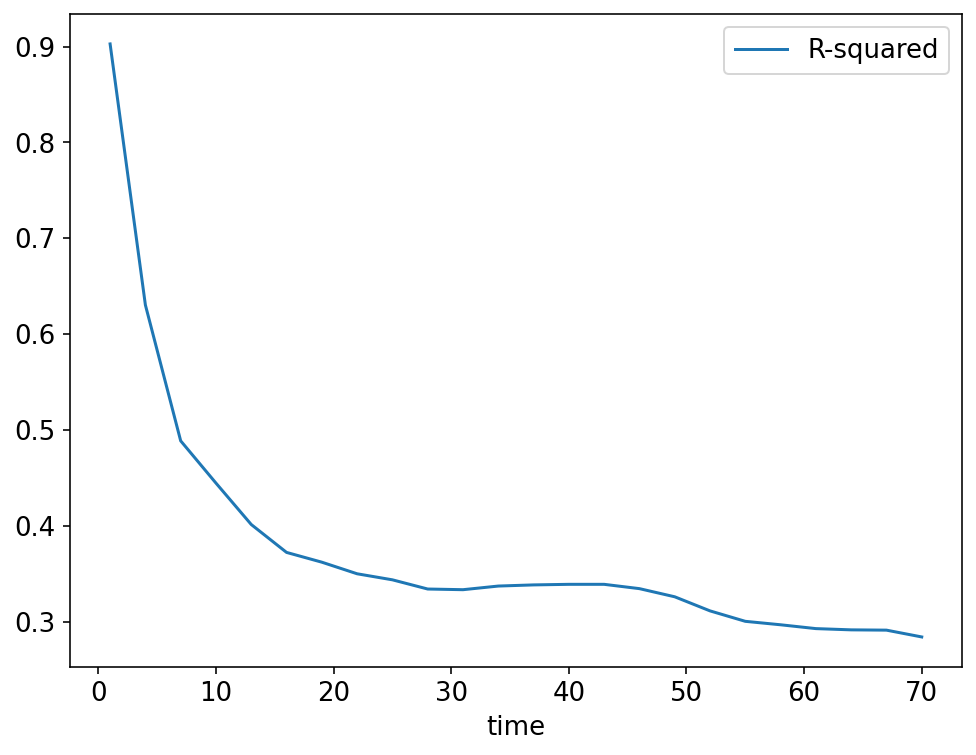

In [76]:
df_r = pd.DataFrame(res, columns=['time','R-squared']).set_index('time')
df_r.plot()

# (실습) 일 단위 예측

In [323]:
df_down = df.set_index("date").resample('D').mean()
print(df_down.shape)
df_down[:3]

(365, 22)


,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,...,d-day,d-dayofweek,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_No,functioning_Yes
date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,397.458333,11.5,-2.454167,45.875000,1.5375,1870.750000,-13.545833,0.248750,0.000000,0.0,...,1.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-12-02,355.125000,11.5,1.325000,61.958333,1.7125,1471.083333,-5.716667,0.263750,0.000000,0.0,...,2.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-12-03,300.916667,11.5,4.875000,81.541667,1.6125,455.750000,1.883333,0.125417,0.166667,0.0,...,3.0,6.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


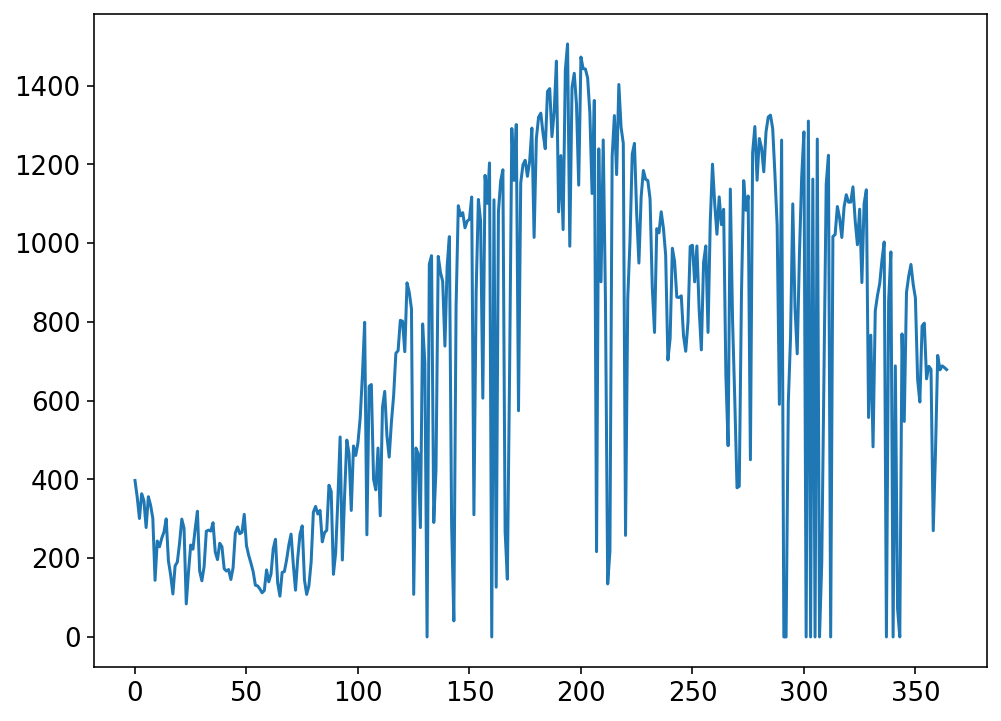

In [324]:
# 일 단위로 보기
count_d = df_down["count"].values
plt.plot(count_d)